# Import data

In [5]:
import pandas as pd

data = pd.read_csv("../single_parameter/combined_data/statistics.csv")
data.head()

,RunId,TargetModule,Algorithm,AlgorithmIterations,SearchTime,TuningParameters,Coverage,CoverageTimeline_T1,CoverageTimeline_T2,CoverageTimeline_T3,...,CoverageTimeline_T291,CoverageTimeline_T292,CoverageTimeline_T293,CoverageTimeline_T294,CoverageTimeline_T295,CoverageTimeline_T296,CoverageTimeline_T297,CoverageTimeline_T298,CoverageTimeline_T299,CoverageTimeline_T300
0,flutils.decorators#247,flutils.decorators,DYNAMOSA_RL,1513,300064136954,TestChangeProbability,0.666667,0.666667,0.666667,0.666667,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
1,codetiming._timer#100,codetiming._timer,DYNAMOSA_RL,1001,300064143210,Elite,0.888889,0.555556,0.555556,0.629630,...,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889
2,codetiming._timer#222,codetiming._timer,DYNAMOSA_RL,1516,300085846117,StatementInsertionProbability,0.888889,0.444444,0.666667,0.696566,...,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889
3,flutils.decorators#327,flutils.decorators,DYNAMOSA_RL,1510,300133832198,TestInsertProbability,0.666667,0.666667,0.666667,0.666667,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
4,httpie.output.formatters.headers#50,httpie.output.formatters.headers,DYNAMOSA_RL,2089,300206714135,ChromosomeLength,0.600000,0.600000,0.600000,0.600000,...,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000


# Coverage Distribution plot

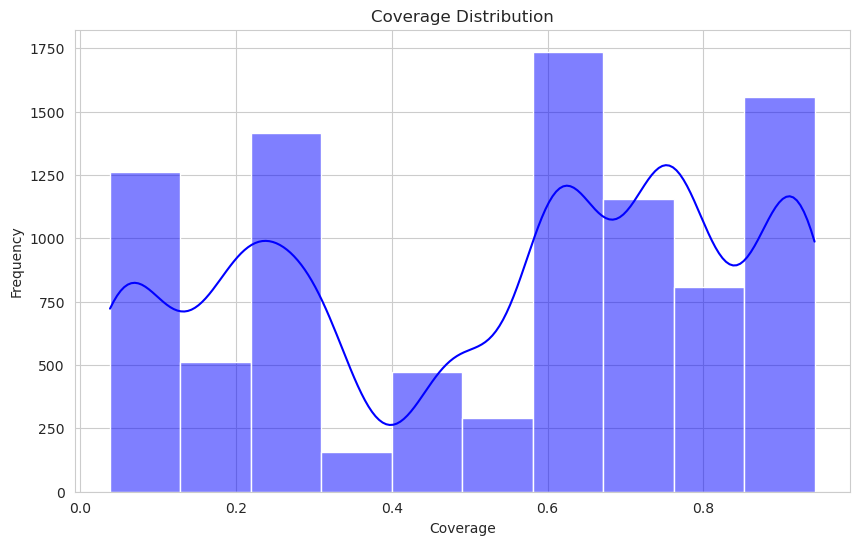

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb

# Style
sb.set_style('whitegrid')

plt.figure(figsize=(10,6))
sb.histplot(data['Coverage'], bins=10, kde=True, color='blue')
plt.title('Coverage Distribution')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.show()

In [7]:
import pymc as pm
import formulaic
import pandas as pd
import numpy as np

model_formula = 'Coverage ~ 0 + C(TargetModule)'
model_spec = formulaic.model_matrix(model_formula, data=data)

group_idx = pd.Categorical(data['TargetModule']).codes
group_idx

array([ 1,  0,  0, ..., 18, 22, 20], dtype=int8)

In [8]:
with pm.Model() as model:
    # Priors for the global intercept
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard deviation across groups
    sigma = pm.Exponential('sigma', 1)
    
    # Group-specific intercepts
    a_j = pm.Normal('a_j', mu=a_bar, sigma=sigma, shape=len(np.unique(group_idx)))
    
    # Deterministic transformations for logit(pi)
    logit_p = pm.Deterministic('logit_p', a_j[group_idx])
    
    # Link function - logistic
    p = pm.Deterministic('p', pm.math.sigmoid(logit_p))
    
    # Gamma distribution for theta - dispersion parameter
    theta = pm.Gamma('theta', alpha=2, beta=0.5)  # adjust alpha, beta to reflect your prior knowledge
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=data['Coverage'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4, return_inferencedata=True)

print("Model building complete.")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [a_bar, sigma, a_j, theta]


/home/erik/miniconda3/envs/analysis_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


Model building complete.


In [10]:
import arviz as az

# Generate a summary of the posterior
summary = az.summary(trace, var_names=['a_j', 'a_bar', 'sigma', 'theta'])



In [11]:
categories = pd.Categorical(data['TargetModule'])
code_to_group = dict(enumerate(categories.categories))

# Now, `code_to_group` is a dictionary where keys are codes and values are the original group names
print(code_to_group)

print(summary)

{0: 'codetiming._timer', 1: 'flutils.decorators', 2: 'flutils.namedtupleutils', 3: 'flutils.packages', 4: 'flutils.setuputils.cmd', 5: 'httpie.output.formatters.headers', 6: 'httpie.plugins.base', 7: 'mimesis.builtins.da', 8: 'py_backwards.transformers.base', 9: 'py_backwards.transformers.dict_unpacking', 10: 'py_backwards.transformers.return_from_generator', 11: 'py_backwards.transformers.yield_from', 12: 'py_backwards.utils.helpers', 13: 'pymonet.immutable_list', 14: 'pymonet.maybe', 15: 'pymonet.validation', 16: 'pypara.accounting.journaling', 17: 'pytutils.lazy.lazy_import', 18: 'pytutils.python', 19: 'sanic.config', 20: 'sanic.helpers', 21: 'sanic.mixins.signals', 22: 'thonny.plugins.pgzero_frontend', 23: 'typesystem.tokenize.positional_validation'}
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a_j[0]    1.930  0.023   1.887    1.973      0.000    0.000   10751.0   
a_j[1]    0.676  0.016   0.646    0.708      0.000    0.000   10818.0   
a_j[2]    2.627 

array([[<Axes: title={'center': 'a_j'}>, <Axes: title={'center': 'a_j'}>]],
      dtype=object)

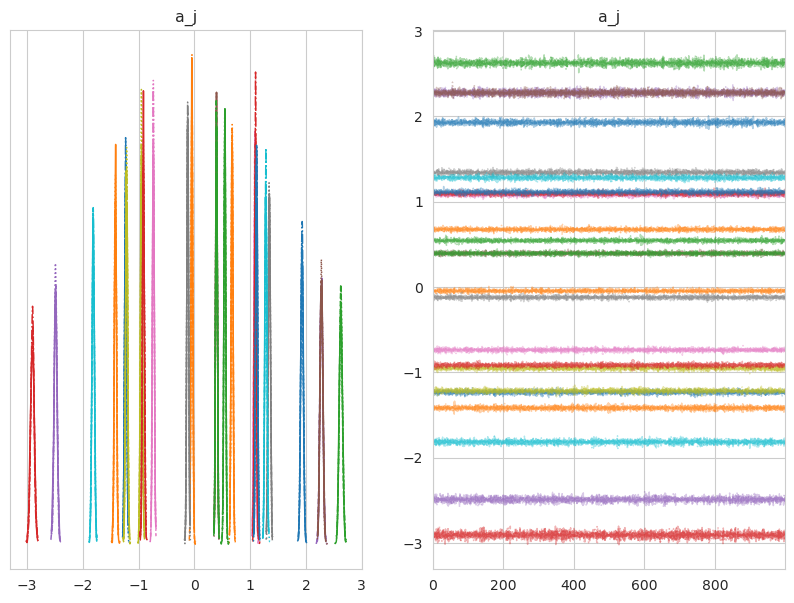

In [12]:
az.plot_trace(trace, var_names=['a_j'], figsize=(10, 7))

# Data preperation

In [28]:
import pymc as pm
import formulaic
import pandas as pd
import numpy as np

model_formula = 'Coverage ~ C(TargetModule) * C(TuningParameters, Treatment(reference="NONE"))'
model_spec = formulaic.model_matrix(model_formula, data=data)

y = model_spec.lhs
x = model_spec.rhs

In [34]:
with pymc.Model() as model:
    # Priors
    coefs = pymc.Normal('coefs', mu=0, sigma=10, shape=(x.shape[1],))  # One coefficient per predictor
    phi = pymc.Gamma('phi', alpha=2, beta=0.5)  # Precision of the Beta distribution

    # Expected value of outcome
    eta = pymc.math.dot(x, coefs)  # Linear combination of predictors and coefficients
    mu = pymc.math.sigmoid(eta)  # Link function, logistic

    # Likelihood
    Y_obs = pymc.Beta('Y_obs', alpha=mu * phi, beta=(1 - mu) * phi, observed=y['Coverage'])

    # Posterior sampling
    trace = pymc.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [coefs, phi]


/home/henrik/miniconda3/envs/analysis_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 861 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [35]:
import arviz as az
# Summarize the model outputs

summary = az.summary(trace) #pymc.summary(trace)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],1.933,0.063,1.814,2.039,0.014,0.010,20.0,39.0,1.12
coefs[1],-1.261,0.088,-1.420,-1.090,0.016,0.011,32.0,63.0,1.06
coefs[2],0.701,0.123,0.479,0.948,0.018,0.013,46.0,149.0,1.06
coefs[3],-4.746,0.124,-4.978,-4.513,0.015,0.011,66.0,129.0,1.04
coefs[4],-4.430,0.117,-4.648,-4.223,0.019,0.014,37.0,117.0,1.06
...,...,...,...,...,...,...,...,...,...
coefs[308],-0.096,0.143,-0.373,0.167,0.021,0.015,48.0,78.0,1.05
coefs[309],-0.055,0.146,-0.327,0.213,0.021,0.015,50.0,268.0,1.05
coefs[310],-0.053,0.138,-0.307,0.206,0.023,0.016,37.0,114.0,1.06
coefs[311],-0.213,0.136,-0.459,0.042,0.019,0.014,50.0,86.0,1.03


array([[<Axes: title={'center': 'coefs'}>,
        <Axes: title={'center': 'coefs'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>]],
      dtype=object)

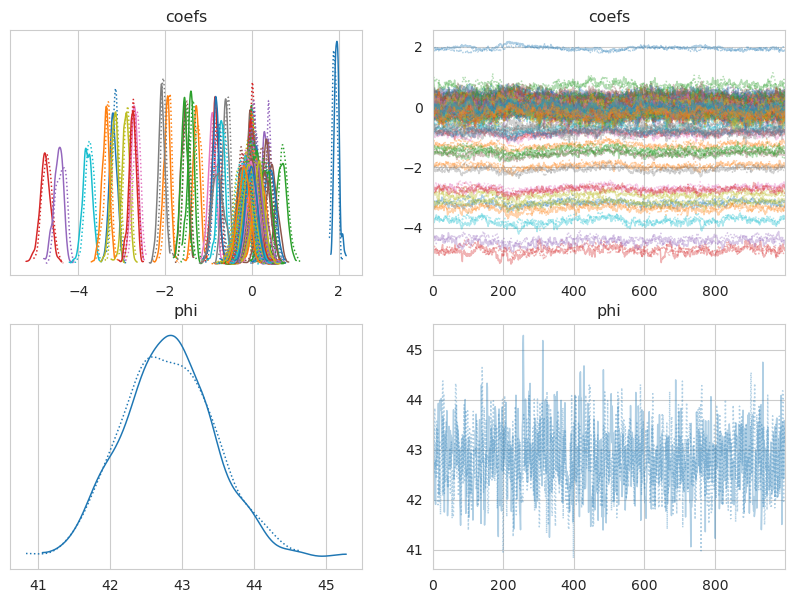

In [36]:
az.plot_trace(trace, figsize=(10, 7))